In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show(path):
    img_arr = np.array(Image.open(path))
    plt.imshow(img_arr)
    plt.axis('off')
    plt.show()

In [2]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms

class UnderWaterImages(Dataset):
    def __init__(self,folder,transforms=None):
        self.raw = os.path.join(folder,'Raw')
        self.ref = os.path.join(folder,'Reference')
        self.image_names = os.listdir(self.raw)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self,idx):
        img_name = self.image_names[idx]
        raw_path = os.path.join(self.raw,img_name)
        ref_path = os.path.join(self.ref,img_name)
        raw_img = Image.open(raw_path).convert('RGB')
        ref_img = Image.open(ref_path).convert('RGB')

        if self.transforms:
            raw_img = self.transforms(raw_img)
            ref_img = self.transforms(ref_img)
        return raw_img,ref_img

In [3]:
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

In [4]:
train_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Train',transforms)

In [5]:
test_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Test',transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# from torch.utils.data import random_split, DataLoader
# dataset_size = len(train_dataset)
# val_size = int(0.2 * dataset_size)   
# train_size = dataset_size - val_size
# train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [24]:
import functools
import torch
import torch.nn as nn
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None, submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            # upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)

            upconv = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(inner_nc * 2,outer_nc,kernel_size=3, padding=1), 
            )
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            # upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            upconv = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(inner_nc ,outer_nc, kernel_size=3, padding=1,bias=use_bias), 
            )            
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            # upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            upconv = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(inner_nc * 2, outer_nc, kernel_size=3, padding=1,bias=use_bias), 
            )              
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:  # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [25]:
class UNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, use_dropout=False, norm_layer=nn.BatchNorm2d):
        super().__init__()

        #deepest layer
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)

        for i in range(num_downs - 5):  # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)

        #outermost layer
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

    def forward(self, input):
        return self.model(input)

In [26]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super().__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers): 
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias), norm_layer(ndf * nf_mult), nn.LeakyReLU(0.2, True)]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias), norm_layer(ndf * nf_mult), nn.LeakyReLU(0.2, True)]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [27]:
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super().__init__()
        self.register_buffer("real_label", torch.tensor(target_real_label))
        self.register_buffer("fake_label", torch.tensor(target_fake_label))
        self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        
        # if target_is_real:
        #     loss = -prediction.mean()
        # else:
        #     loss = prediction.mean()
        
        return loss

In [28]:
def define_G(input_nc, output_nc, ngf,use_dropout=False):
    norm_layer = nn.InstanceNorm2d
    net = UNetGenerator(input_nc, output_nc, 7, ngf,use_dropout=use_dropout,norm_layer=norm_layer)
    # net = UnetGenerator(input_nc, output_nc, 8, ngf,use_dropout=use_dropout)
    return net
    
def define_D(input_nc, ndf, n_layers_D=3):
    # net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    norm_layer = nn.InstanceNorm2d
    net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    # net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    return net

In [29]:
class Pix2PixModel:  
    def __init__(self, opt):
        
        # if train:
        #     self.model_names = ["G", "D"]
        # else: 
        #     self.model_names = ["G"]
        
        self.curr_loss_G_GAN = 0
        self.curr_loss_G_L1=0
        self.curr_loss_D_fake=0
        self.curr_loss_D_real=0
        
        self.opt = opt
        self.device = self.opt["device"]
        self.inputSize = self.opt['input_size']

        self.netG = define_G(self.opt["input_nc"], self.opt["output_nc"], self.opt["n_filters"], not self.opt["no_dropout"]).to(self.device)

        self.netD = define_D(self.opt["input_nc"]+self.opt["output_nc"], self.opt["n_filters"],self.opt["n_layers_D"]).to(self.device)

        self.criterionGAN = GANLoss().to(self.device)
        self.criterionL1 = torch.nn.L1Loss()
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=self.opt["lr"], betas=(self.opt["beta1"], 0.999))
        self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=self.opt["lr"], betas=(self.opt["beta1"], 0.999))
    
    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
    

    def set_input(self, real_A, real_B):
        self.real_A = real_A.to(self.device)
        self.real_B = real_B.to(self.device)
        

                    
    def forward(self,real_A = None,epoch=None,test=False):
        """Run forward pass"""
        if real_A is not None:
            real_A = real_A.to(self.device)
            fake_B = self.netG(real_A)
            if test:
                return fake_B
            self.fake_B = fake_B
        else:
            self.fake_B = self.netG(self.real_A)

    def backward_D(self,epoch):
        """Calculate GAN loss for the discriminator"""
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator
        pred_fake = self.netD(fake_AB.detach())
        self.loss_D_fake = self.criterionGAN(pred_fake, False)
        self.curr_loss_D_fake += self.loss_D_fake
        
        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.criterionGAN(pred_real, True)
        self.curr_loss_D_real += self.loss_D_real

        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self,epoch):
        """Calculate GAN and L1 loss for the generator"""
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB)
        
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)
        self.curr_loss_G_GAN += self.loss_G_GAN
        
        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt["lambda_L1"]
        self.curr_loss_G_L1 += self.loss_G_L1
            
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize_parameters(self,epoch):
        self.forward()  # compute fake images: G(A)
        self.set_requires_grad(self.netD, True)  # enable backprop for D
        self.optimizer_D.zero_grad()  # set D's gradients to zero
        self.backward_D(epoch)  # calculate gradients for D
        self.optimizer_D.step()  # update D's weights
        # update G
        self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
        self.optimizer_G.zero_grad()  # set G's gradients to zero
        self.backward_G(epoch)  # calculate graidents for G
        self.optimizer_G.step()  # update G's weights        

In [13]:
#parameters of the model
opt = {
    "device": torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu',
    "input_nc": 3,
    "output_nc": 3,
    "n_filters": 64,
    "no_dropout": 1,
    "lr": 0.0002,
    "beta1": 0.5,
    "lambda_L1": 100,
    "n_layers_D": 3,
    "input_size":700
}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
model = Pix2PixModel(opt)

In [16]:
from tqdm.notebook import tqdm 
epochs = 20
def train(epoch):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Train Epoch {epoch}/{epochs}")
    for batch_idx, (raw,ref) in pbar:
        raw = raw.to(device)      
        model.set_input(raw,ref)
        model.optimize_parameters(epoch)
        
    print(f"G_L1: {float(model.curr_loss_G_L1 / model.inputSize):.3f} | G_GAN: {float(model.curr_loss_G_GAN / model.inputSize):.3f} | D_fake: {float(model.curr_loss_D_fake / model.inputSize):.3f} | D_real: {float(model.curr_loss_D_real / model.inputSize):.3f}")
        
    model.curr_loss_G_L1 = 0
    model.curr_loss_G_GAN = 0
    model.curr_loss_D_real = 0 
    model.curr_loss_D_fake = 0 

In [27]:
import torch
import os
import matplotlib.pyplot as plt

epochs = 20
best_val_loss = float('inf')
patience = 10 
patience_counter = 0

save_epochs = [int(frac * epochs) for frac in [0.1, 0.3, 0.5, 0.7 , 0.9, 1.0]]
fixed_raw, fixed_ref = next(iter(train_loader))
fixed_raw, fixed_ref = fixed_raw.to(device), fixed_ref.to(device)

os.makedirs("results", exist_ok=True)

def save_reconstruction(model, data, ref, epoch, step_fraction):
    with torch.no_grad():
        recon= model.forward(real_A=data,test=True)
    recon = recon[0].cpu()
    data = data[0].cpu()
    ref = ref[0].cpu()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(data.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    axes[1].imshow(recon.permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    axes[2].imshow(ref.permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Reference")
    axes[2].axis("off")    

    plt.tight_layout()
    plt.savefig(f"results/epoch{epoch}_step{step_fraction}.png")
    plt.close()

for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch in save_epochs:
        save_reconstruction(model, fixed_raw, fixed_ref, epoch, int(epoch / epochs * 100))

Train Epoch 1/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.976 | G_GAN: 0.054 | D_fake: 0.012 | D_real: 0.012


Train Epoch 2/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.441 | G_GAN: 0.092 | D_fake: 0.006 | D_real: 0.005


Train Epoch 3/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.360 | G_GAN: 0.084 | D_fake: 0.008 | D_real: 0.006


Train Epoch 4/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.323 | G_GAN: 0.102 | D_fake: 0.004 | D_real: 0.004


Train Epoch 5/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.299 | G_GAN: 0.073 | D_fake: 0.014 | D_real: 0.015


Train Epoch 6/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.282 | G_GAN: 0.048 | D_fake: 0.015 | D_real: 0.014


Train Epoch 7/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.274 | G_GAN: 0.057 | D_fake: 0.013 | D_real: 0.012


Train Epoch 8/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.271 | G_GAN: 0.062 | D_fake: 0.014 | D_real: 0.012


Train Epoch 9/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.267 | G_GAN: 0.070 | D_fake: 0.011 | D_real: 0.011


Train Epoch 10/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.265 | G_GAN: 0.082 | D_fake: 0.011 | D_real: 0.010


Train Epoch 11/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.264 | G_GAN: 0.103 | D_fake: 0.009 | D_real: 0.008


Train Epoch 12/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.259 | G_GAN: 0.093 | D_fake: 0.006 | D_real: 0.006


Train Epoch 13/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.258 | G_GAN: 0.096 | D_fake: 0.012 | D_real: 0.011


Train Epoch 14/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.259 | G_GAN: 0.119 | D_fake: 0.006 | D_real: 0.005


Train Epoch 15/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.258 | G_GAN: 0.140 | D_fake: 0.003 | D_real: 0.003


Train Epoch 16/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.257 | G_GAN: 0.124 | D_fake: 0.009 | D_real: 0.007


Train Epoch 17/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.256 | G_GAN: 0.134 | D_fake: 0.002 | D_real: 0.002


Train Epoch 18/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.253 | G_GAN: 0.161 | D_fake: 0.001 | D_real: 0.002


Train Epoch 19/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.251 | G_GAN: 0.132 | D_fake: 0.008 | D_real: 0.010


Train Epoch 20/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.252 | G_GAN: 0.123 | D_fake: 0.005 | D_real: 0.005


In [28]:
torch.save({
    'epoch': epoch,
    'netG_state_dict': model.netG.state_dict(),
    'netD_state_dict': model.netD.state_dict(),
    'optimizer_G_state_dict': model.optimizer_G.state_dict(),
    'optimizer_D_state_dict': model.optimizer_D.state_dict(),
    'loss_G_L1': model.curr_loss_G_L1,
    'loss_G_GAN': model.curr_loss_G_GAN,
    'loss_D_fake': model.curr_loss_D_fake,
    'loss_D_real': model.curr_loss_D_real,
}, "checkpoint.pth")


In [32]:
def display_results(loader):
    fig,axes = plt.subplots(5,3,figsize=(15,10))
    for i,(batch_raw,batch_ref) in enumerate(loader):
        if i>=5: break
           
        batch_raw, batch_ref = batch_raw.to(device), batch_ref.to(device)
        batch_recon = model.forward(real_A=batch_raw,test=True)
        
        recon = batch_recon[0].detach().cpu()
        raw = batch_raw[0].detach().cpu()
        ref = batch_ref[0].detach().cpu()
            
        axes[i][0].imshow(raw.permute(1,2,0).clamp(0,1))
        axes[i][0].set_title("Noisy")
        axes[i][0].axis("off")
        axes[i][1].imshow(recon.permute(1,2,0).clamp(0,1))
        axes[i][1].set_title("Reconstructed")
        axes[i][1].axis("off")
        axes[i][2].imshow(ref.permute(1,2,0).clamp(0,1))
        axes[i][2].set_title("Clean image")
        axes[i][2].axis("off")
    
 

    plt.tight_layout()
    plt.savefig(f"results.png")
    plt.show()

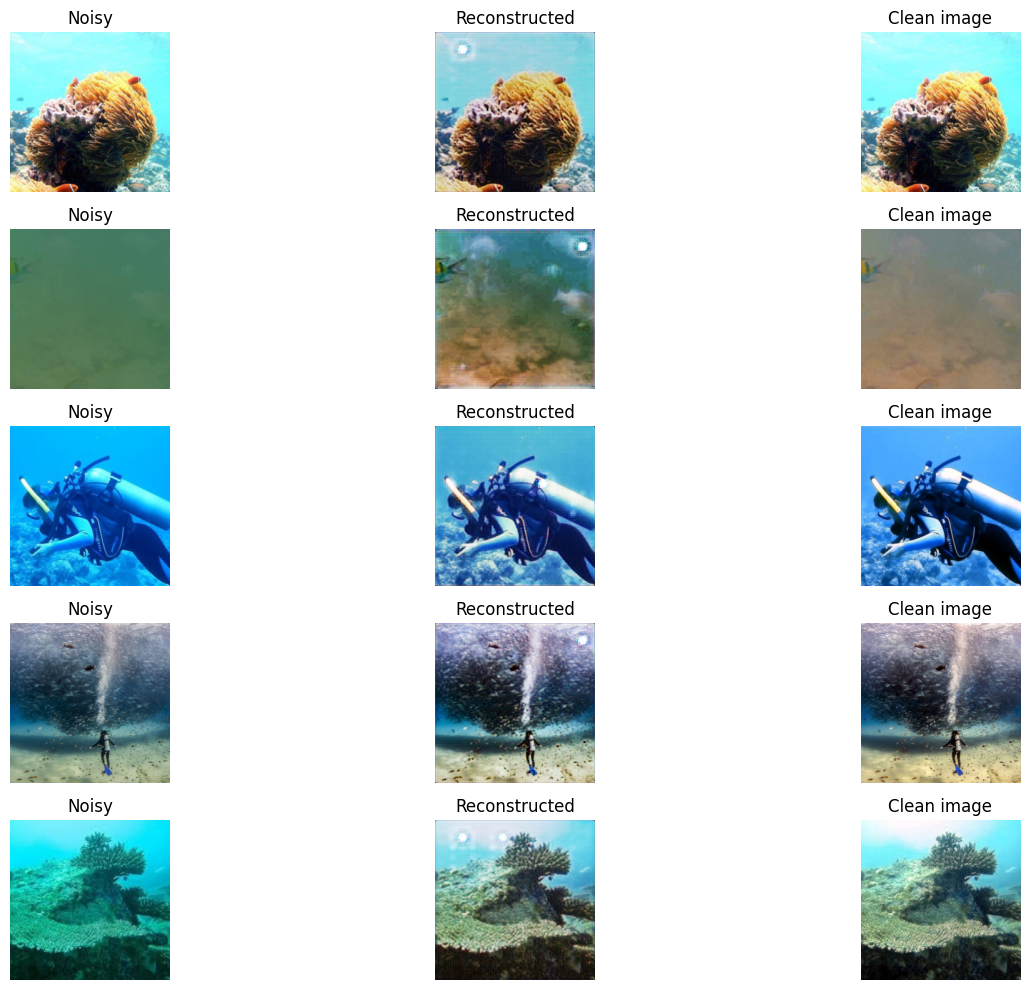

In [32]:
display_results(test_loader)

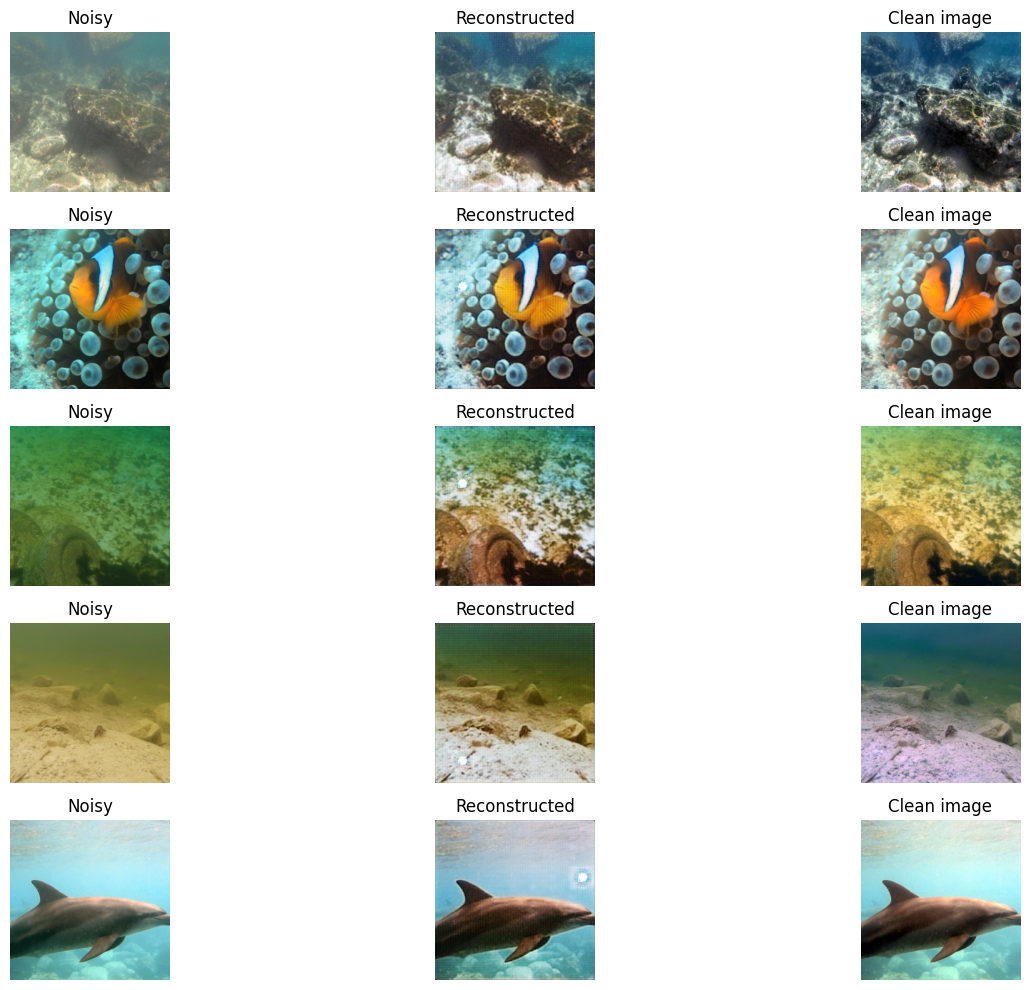

In [33]:
display_results(train_loader)

In [35]:
# Save only the models (smaller, easier to download)
torch.save(model.netG.state_dict(), "netG.pth")
torch.save(model.netD.state_dict(), "netD.pth")
torch.save(model.optimizer_G.state_dict(), "optimG.pth")
torch.save(model.optimizer_D.state_dict(), "optimD.pth")

* **Observation:** Wierd white bright dot 
* **Reason:** Due to the usage of ConvTranspose2d
* **Experiment:** Use ConvTranspose2d

In [31]:
import torch
import os
import matplotlib.pyplot as plt

epochs = 20
best_val_loss = float('inf')
patience = 10 
patience_counter = 0

save_epochs = [int(frac * epochs) for frac in [0.1, 0.3, 0.5, 0.7 , 0.9, 1.0]]
fixed_raw, fixed_ref = next(iter(train_loader))
fixed_raw, fixed_ref = fixed_raw.to(device), fixed_ref.to(device)

os.makedirs("results", exist_ok=True)

def save_reconstruction(model, data, ref, epoch, step_fraction):
    with torch.no_grad():
        recon= model.forward(real_A=data,test=True)
    recon = recon[0].cpu()
    data = data[0].cpu()
    ref = ref[0].cpu()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(data.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    axes[1].imshow(recon.permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    axes[2].imshow(ref.permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Reference")
    axes[2].axis("off")    

    plt.tight_layout()
    plt.savefig(f"results/epoch{epoch}_step{step_fraction}.png")
    plt.close()

for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch in save_epochs:
        save_reconstruction(model, fixed_raw, fixed_ref, epoch, int(epoch / epochs * 100))

Train Epoch 1/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.635 | G_GAN: 0.041 | D_fake: 0.018 | D_real: 0.016


Train Epoch 2/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.296 | G_GAN: 0.034 | D_fake: 0.020 | D_real: 0.020


Train Epoch 3/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.283 | G_GAN: 0.042 | D_fake: 0.018 | D_real: 0.017


Train Epoch 4/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.270 | G_GAN: 0.032 | D_fake: 0.019 | D_real: 0.019


Train Epoch 5/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.265 | G_GAN: 0.035 | D_fake: 0.016 | D_real: 0.018


Train Epoch 6/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.263 | G_GAN: 0.047 | D_fake: 0.013 | D_real: 0.013


Train Epoch 7/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.261 | G_GAN: 0.052 | D_fake: 0.013 | D_real: 0.014


Train Epoch 8/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.259 | G_GAN: 0.055 | D_fake: 0.010 | D_real: 0.011


Train Epoch 9/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.260 | G_GAN: 0.065 | D_fake: 0.008 | D_real: 0.009


Train Epoch 10/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.255 | G_GAN: 0.068 | D_fake: 0.008 | D_real: 0.010


Train Epoch 11/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.251 | G_GAN: 0.077 | D_fake: 0.006 | D_real: 0.007


Train Epoch 12/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.250 | G_GAN: 0.081 | D_fake: 0.006 | D_real: 0.007


Train Epoch 13/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.245 | G_GAN: 0.079 | D_fake: 0.006 | D_real: 0.008


Train Epoch 14/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.241 | G_GAN: 0.088 | D_fake: 0.004 | D_real: 0.005


Train Epoch 15/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.222 | G_GAN: 0.055 | D_fake: 0.024 | D_real: 0.025


Train Epoch 16/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.224 | G_GAN: 0.066 | D_fake: 0.008 | D_real: 0.009


Train Epoch 17/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.221 | G_GAN: 0.071 | D_fake: 0.008 | D_real: 0.011


Train Epoch 18/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.218 | G_GAN: 0.076 | D_fake: 0.009 | D_real: 0.012


Train Epoch 19/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.209 | G_GAN: 0.079 | D_fake: 0.005 | D_real: 0.005


Train Epoch 20/20:   0%|          | 0/22 [00:00<?, ?it/s]

G_L1: 0.202 | G_GAN: 0.087 | D_fake: 0.005 | D_real: 0.007


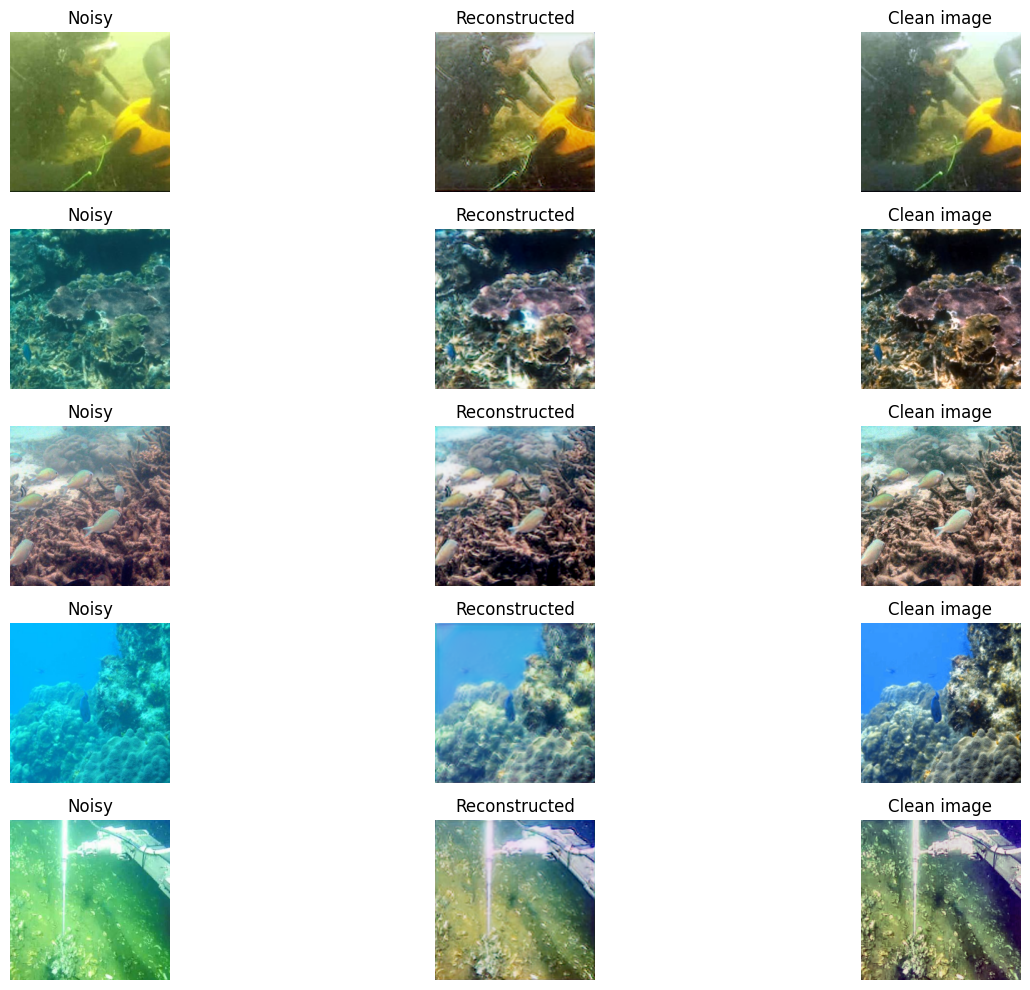

In [33]:
display_results(test_loader)

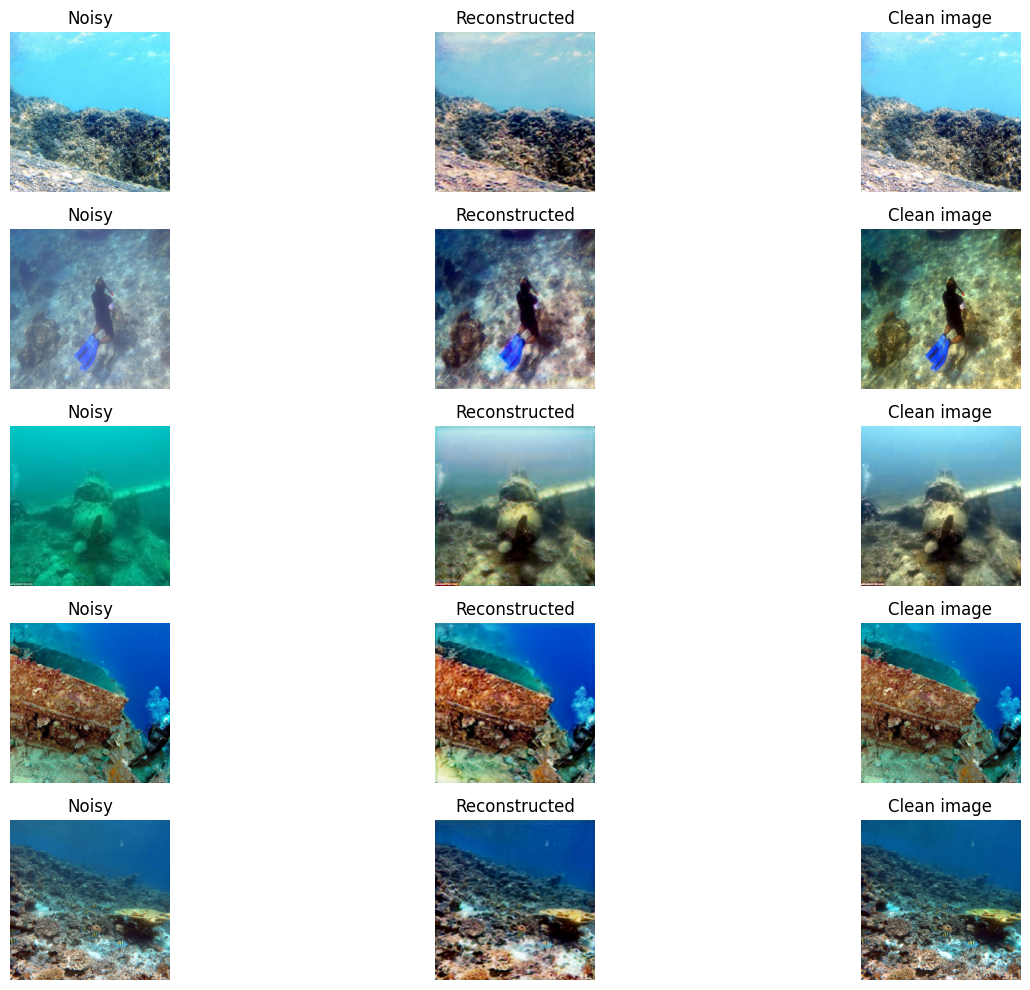

In [34]:
display_results(train_loader)

**Results**

In [47]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def compute_metrics_batch(original_batch, reconstructed_batch):
    batch_size = original_batch.size(0)
    original_batch = original_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)
    reconstructed_batch = reconstructed_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)

    mse_list = []
    psnr_list = []
    ssim_list = []

    for i in range(batch_size):
        orig = original_batch[i]
        recon = reconstructed_batch[i]

        mse_list.append(mean_squared_error(orig, recon))
        psnr_list.append(peak_signal_noise_ratio(orig, recon, data_range=255))
        ssim_list.append(structural_similarity(orig, recon, channel_axis=-1, data_range=255))

    mse_avg = np.mean(mse_list)
    psnr_avg = np.mean(psnr_list)
    ssim_avg = np.mean(ssim_list)

    return mse_avg, psnr_avg, ssim_avg

In [48]:
mse_total = 0.0
psnr_total = 0.0
ssim_total = 0.0
num_batches = 0

with torch.no_grad():
    for (batch_raw,batch_ref) in test_loader:
        batch_raw, batch_ref = batch_raw.to(device), batch_ref.to(device)
        batch_recon = model.forward(real_A=batch_raw,test=True)     

        mse, psnr, ssim = compute_metrics_batch(batch_ref, batch_recon)

        mse_total += mse
        psnr_total += psnr
        ssim_total += ssim
        num_batches += 1

mse_avg = mse_total / num_batches
psnr_avg = psnr_total / num_batches
ssim_avg = ssim_total / num_batches

print(f"Test MSE: {mse_avg:.4f}")
print(f"Test PSNR: {psnr_avg:.2f} dB")
print(f"Test SSIM: {ssim_avg:.4f}")

Test MSE: 0.0134
Test PSNR: 67.75 dB
Test SSIM: 0.9984


**Testing saved model**

In [41]:
model_test = Pix2PixModel(opt)
raw,ref = next(iter(test_loader))
model_test.set_input(raw,ref)
model_test.netG.load_state_dict(torch.load("netG.pth", map_location="cpu"))
model_test.netG.to(device)

UNetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), strid

In [45]:
def display_results_test(loader):
    fig,axes = plt.subplots(5,3,figsize=(15,10))
    for i,(batch_raw,batch_ref) in enumerate(loader):
        if i>=5: break
           
        batch_raw, batch_ref = batch_raw.to(device), batch_ref.to(device)
        batch_recon = model_test.netG(batch_raw)
        
        recon = batch_recon[0].detach().cpu()
        raw = batch_raw[0].detach().cpu()
        ref = batch_ref[0].detach().cpu()
            
        axes[i][0].imshow(raw.permute(1,2,0).clamp(0,1))
        axes[i][0].set_title("Noisy")
        axes[i][0].axis("off")
        axes[i][1].imshow(recon.permute(1,2,0).clamp(0,1))
        axes[i][1].set_title("Reconstructed")
        axes[i][1].axis("off")
        axes[i][2].imshow(ref.permute(1,2,0).clamp(0,1))
        axes[i][2].set_title("Clean image")
        axes[i][2].axis("off")
    
 

    plt.tight_layout()
    plt.savefig(f"results.png")
    plt.show()

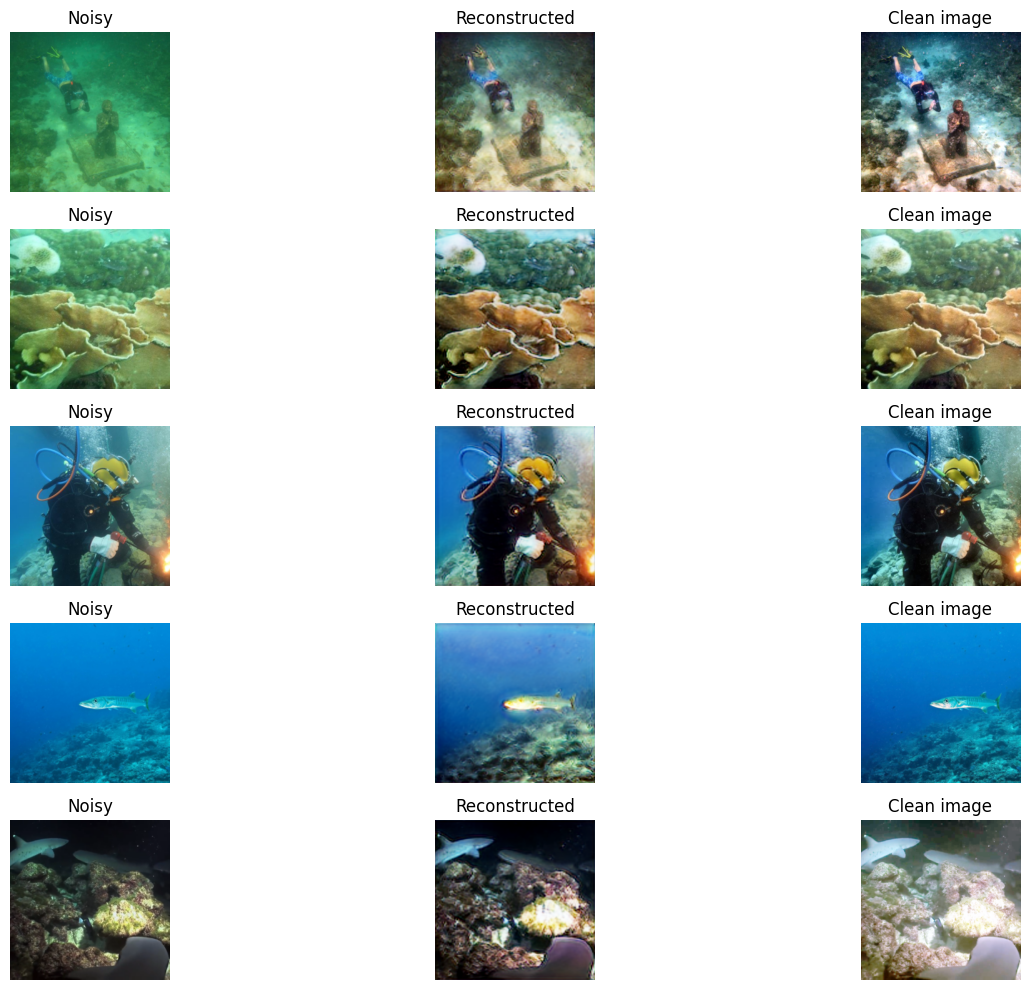

In [46]:
display_results_test(test_loader)